In [198]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-13 20:29:02--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.3’

mnist_test_seq.npy. 100%[===================>] 781.25M  13.6MB/s    in 59s     

2020-05-13 20:30:02 (13.2 MB/s) - ‘mnist_test_seq.npy.3’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

In [218]:
# Data processing
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:1000, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
data = data/np.amax(data) # normalize between 0 and 1 (min-max scaling)
N, F, H, W, C = data.shape # dims
print('dataset = '+str(data.shape)) # shape is [instance x frame x height x width x channel]

dataset = (1000, 20, 64, 64, 1)


In [219]:
# Create Input/output dataset: 
# previous frame (X_t-1) is used as input to predict next frame (y_t)
def shift_data(data, cutoff):
  N = data.shape[1]
  X = data[:, :cutoff, :, :, :]
  y = data[:, 1:cutoff+1, :, :, :]
  return X, y
init_traj = 10
X, y = shift_data(data, init_traj)
print("X is:", X.shape)
print("y is:", y.shape)

X is: (1000, 10, 64, 64, 1)
y is: (1000, 10, 64, 64, 1)


In [220]:
def MCNet_data(X, y):
  y_MCNet = y[:, -1, :, :, :]
  X_MCNet = X.copy()
  X_MCNet[:, :-1, :, :, :] = X[:, 1:, :, :, :] - X[:, :-1, :, :, :]
  return X_MCNet, y_MCNet
X_MCNet, y_MCNet = MCNet_data(X, y)
print("X_MCNet is:", X_MCNet.shape)
print("y_MCNet is:", y_MCNet.shape)

X_MCNet is: (1000, 10, 64, 64, 1)
y_MCNet is: (1000, 64, 64, 1)


In [221]:
X_MCNet = tf.cast(X_MCNet, tf.float32)
y_MCNet = tf.cast(y_MCNet, tf.float32)
print("X_MCNet is:", X_MCNet.shape)
print("y_MCNet is:", y_MCNet.shape)

X_MCNet is: (1000, 10, 64, 64, 1)
y_MCNet is: (1000, 64, 64, 1)


In [0]:
# Our Model Architecture
def model_init():
    inputs = tf.keras.Input(shape=[None, H, W, C])
    # # Encoder
    # print(inputs.shape)
    # CL1 = tf.keras.layers.ConvLSTM2D(128, 5, 
    #                                  padding='same', kernel_initializer='he_normal', 
    #                                  return_sequences=True)(inputs)
    # print(CL1.shape)
    # CL2 = tf.keras.layers.ConvLSTM2D(64, 5, 
    #                                  padding='same', kernel_initializer='he_normal', 
    #                                  return_sequences=True)(CL1)
    # # Decoder
    # print(CL2.shape)
    # CL3 = tf.keras.layers.ConvLSTM2D(64, 5, 
    #                                  padding='same', kernel_initializer='he_normal', 
    #                                  return_sequences=True)(CL1)
    # print(CL3.shape)
    # added = tf.keras.layers.Add()([CL2, CL3])
    # CL4 = tf.keras.layers.ConvLSTM2D(32, 5, 
    #                                  padding='same', kernel_initializer='he_normal', 
    #                                  return_sequences=True)(added)
    # # Prediction
    # print(CL4.shape)
    # concat = tf.keras.layers.Concatenate()([CL3, CL4])
    # print(concat.shape)
    # preds = tf.keras.layers.Conv3D(1, 1, 
    #                                activation='sigmoid', 
    #                                padding='same', kernel_initializer='he_normal')(concat)
    # print(preds.shape)
    # Motion Encoder
    # Motion Encoder
    # Layer 1
    tcnv1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer='he_normal'), name='motion_conv_1')(inputs[:, :-1, :, :, :]) 
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)), name='motion_pool_1')(tcnv1) #original (2,2)
    # Layer 2
    tcnv2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same',kernel_initializer='he_normal'), name='motion_conv_2')(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)), name='motion_pool_2')(tcnv2)
    # Layer 3
    tcnv3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, (7,7), activation='relu', padding='same', kernel_initializer='he_normal'), name='motion_conv_3')(x)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D((2,2)), name='motion_pool_3')(tcnv3)
    # Layer 4
    ME = tf.keras.layers.ConvLSTM2D(512, (8,8), activation='relu', padding='same', return_sequences=False, dropout=0.4, recurrent_dropout=0.4, kernel_initializer='he_normal')(x)           
    
    # Content Encoder
    x = tf.keras.layers.Conv2D(64, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(inputs[:, -1, :, :, :])
    x = tf.keras.layers.Conv2D(64, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)    

    x = tf.keras.layers.Conv2D(128, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(128, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x) 

    x = tf.keras.layers.Conv2D(256, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(256, 3, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    CE = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x) 

    # Residuals 
    res3 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv3)
    res2 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv2)
    res1 = tf.keras.layers.Lambda(lambda x: x[:,-1])(tcnv1)


    # Combination layers
    concat = tf.keras.layers.Concatenate()([CE, ME])
    x = tf.keras.layers.Conv2D(256, 5, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(concat)
    x = tf.keras.layers.Conv2D(128, 5, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)
    combined = tf.keras.layers.Conv2D(256, 5, 
                                   activation='relu', 
                                   padding='same', kernel_initializer='he_normal')(x)

    # Decoder layers
    x = tf.keras.layers.UpSampling2D((2,2), name='decoder_upsample_1')(combined)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x) #new
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x) #new

    x = tf.keras.layers.Concatenate()([x, res3]) #res3
    x = tf.keras.layers.UpSampling2D((2,2), name='decoder_upsample_2')(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x) #new

    x = tf.keras.layers.Concatenate()([x, res2])
    x = tf.keras.layers.UpSampling2D((2,2), name='decoder_upsample_3')(x)
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Concatenate()([x, res1]) #res1
    

    # Prediction
    preds = tf.keras.layers.Conv2DTranspose(1, 3, activation='tanh', padding='same', kernel_initializer='he_normal')(x) #sigmoid original
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Custom metrics: SSIM, PSNR, POD, FAR

def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def POD(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_pred_neg = tf.math.logical_not(y_pred_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_pred_neg = tf.cast(y_pred_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  misses = tf.keras.backend.sum(y_gt_pos * y_pred_neg)
  return hits/(hits+misses)

def FAR(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_gt_neg = tf.math.logical_not(y_gt_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_gt_neg = tf.cast(y_gt_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  falsealarms = tf.keras.backend.sum(y_gt_neg * y_pred_pos)
  return falsealarms/(hits+falsealarms)

def CSI(y_gt, y_pred):
  y_gt_pos = tf.math.greater(y_gt, 0)
  y_pred_pos = tf.math.greater(y_pred, 0)
  y_pred_neg = tf.math.logical_not(y_pred_pos)
  y_gt_neg = tf.math.logical_not(y_gt_pos)
  y_gt_pos = tf.cast(y_gt_pos, tf.float32)
  y_pred_pos = tf.cast(y_pred_pos, tf.float32)
  y_gt_neg = tf.cast(y_gt_neg, tf.float32)
  y_pred_neg = tf.cast(y_pred_neg, tf.float32)
  hits = tf.keras.backend.sum(y_gt_pos * y_pred_pos)
  misses = tf.keras.backend.sum(y_gt_pos * y_pred_neg)
  falsealarms = tf.keras.backend.sum(y_gt_neg * y_pred_pos)
  return hits/(hits+misses+falsealarms)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [0]:
# Custom Loss
def mse_modified(y_gt, y_pred, max_val=.1):
  y_gt_pred_eq = tf.math.equal(y_gt, y_pred)
  y_pred_0 = tf.math.equal(y_pred, 0)
  y_both_0 = tf.math.logical_and(y_gt_pred_eq, y_pred_0)
  num_both_0 = tf.math.count_nonzero(y_both_0, dtype=tf.dtypes.float32)
  size_y = tf.size(y_gt, out_type=tf.dtypes.float32)
  return tf.keras.losses.MSE(y_gt, y_pred)*size_y/(size_y - num_both_0 + 1)


def ssim_loss(y_gt, y_pred, max_val=1.):
  return 1-tf.math.reduce_mean(tf.image.ssim(y_gt, y_pred, max_val))

def mse_mae_ssim_loss(y_gt, y_pred, max_val=1.):
  return ssim_loss(y_gt, y_pred, max_val) + \
         tf.keras.losses.MSE(y_gt, y_pred) + \
         tf.keras.losses.MAE(y_gt, y_pred)

In [0]:
# Initialize model
model = model_init()
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mse',
              metrics=['acc', ssim, psnr, POD, FAR, CSI, cor])
# Fit the model
history = model.fit(X_MCNet, y_MCNet, batch_size=50, epochs=10, validation_split=0.1)

Epoch 1/10
18/18 [==============================] - 38s 2s/step - loss: 0.9370 - acc: 0.0581 - ssim: 0.0013 - psnr: 0.2854 - POD: 0.9878 - FAR: 0.9251 - CSI: 0.0748 - cor: 0.0475 - val_loss: 0.9439 - val_acc: 0.0188 - val_ssim: 0.0011 - val_psnr: 0.2511 - val_POD: 1.0000 - val_FAR: 0.9280 - val_CSI: 0.0720 - val_cor: 0.0322
Epoch 2/10
18/18 [==============================] - 39s 2s/step - loss: 0.9437 - acc: 0.0183 - ssim: 0.0010 - psnr: 0.2520 - POD: 1.0000 - FAR: 0.9276 - CSI: 0.0724 - cor: 0.0308 - val_loss: 0.9439 - val_acc: 0.0168 - val_ssim: 0.0011 - val_psnr: 0.2511 - val_POD: 1.0000 - val_FAR: 0.9282 - val_CSI: 0.0718 - val_cor: 0.0303
Epoch 3/10
18/18 [==============================] - 39s 2s/step - loss: 0.9437 - acc: 0.0176 - ssim: 0.0010 - psnr: 0.2520 - POD: 1.0000 - FAR: 0.9276 - CSI: 0.0724 - cor: 0.0302 - val_loss: 0.9439 - val_acc: 0.0166 - val_ssim: 0.0011 - val_psnr: 0.2511 - val_POD: 1.0000 - val_FAR: 0.9282 - val_CSI: 0.0718 - val_cor: 0.0300
Epoch 4/10
18/18 [====

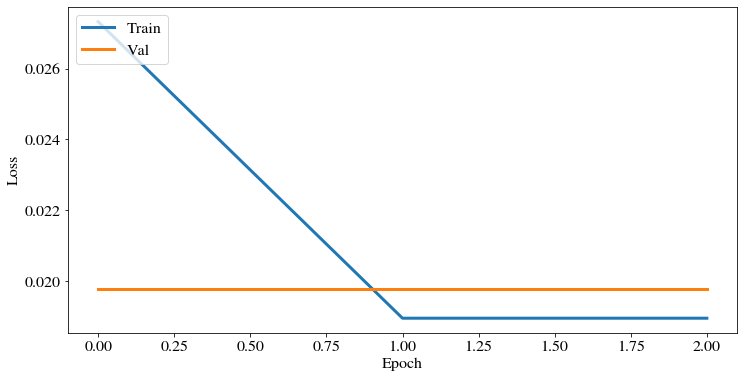

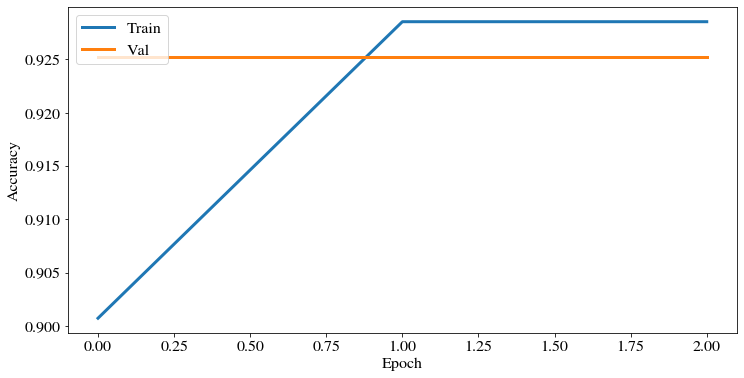

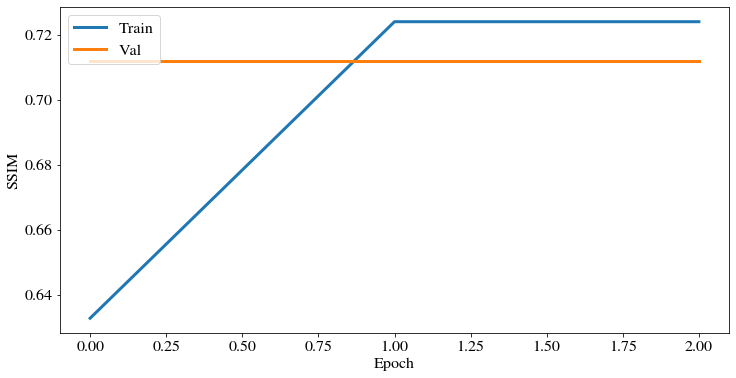

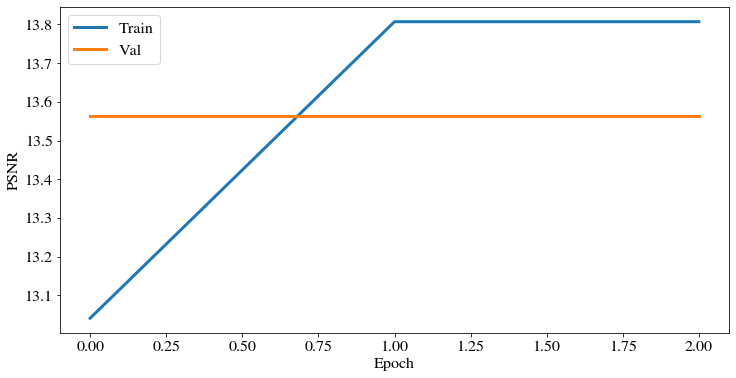

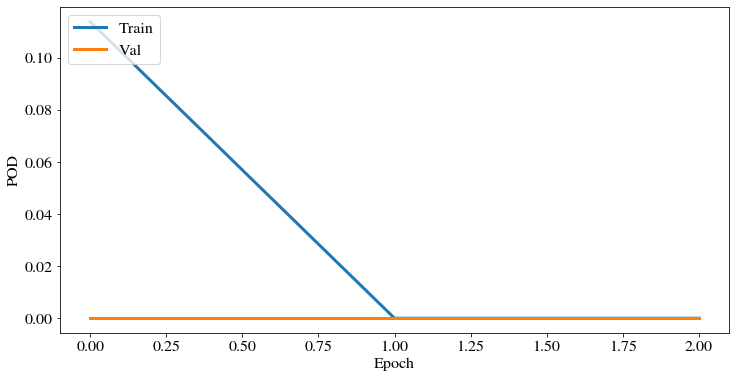

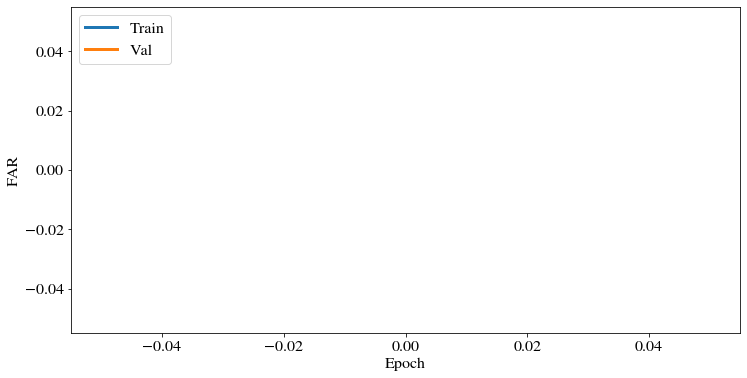

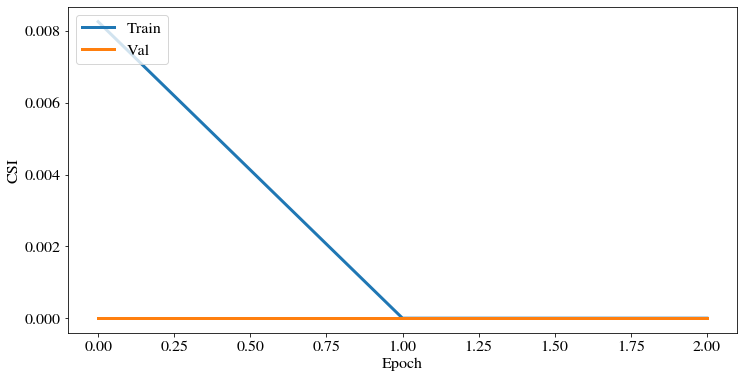

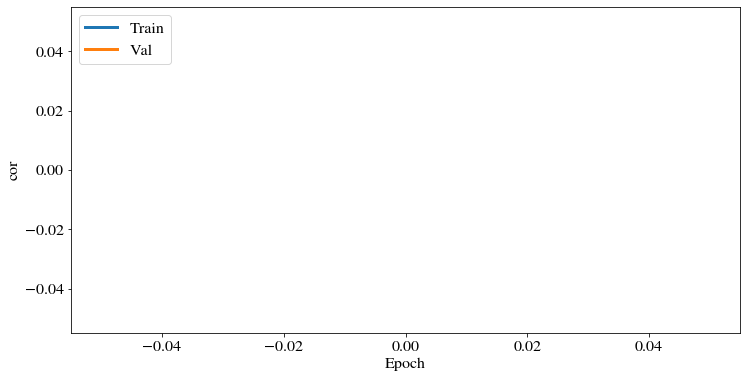

In [161]:
# loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('loss.png')
# files.download('loss.png')

# accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('accuracy.png')
# files.download('accuracy.png')

# ssim
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.ylabel('SSIM')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('ssim.png')
# files.download('ssim.png')

# psnr
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.ylabel('PSNR')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('psnr.png')
# files.download('psnr.png')

# pod
plt.figure(figsize=(12,6))
plt.plot(history.history['POD'], label='Train')
plt.plot(history.history['val_POD'], label='Val')
plt.ylabel('POD')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('pod.png')
# files.download('pod.png')

# far
plt.figure(figsize=(12,6))
plt.plot(history.history['FAR'], label='Train')
plt.plot(history.history['val_FAR'], label='Val')
plt.ylabel('FAR')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('far.png')
# files.download('far.png')

# csi
plt.figure(figsize=(12,6))
plt.plot(history.history['CSI'], label='Train')
plt.plot(history.history['val_CSI'], label='Val')
plt.ylabel('CSI')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('csi.png')
# files.download('csi.png')

# cor
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.ylabel('cor')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
# plt.savefig('cor.png')
# files.download('cor.png')

In [216]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 50
init_traj = 10
pred_traj = data.shape[1] - init_traj
track_MCNet = X_MCNet[itest, :init_traj, :, :, :]
track = X[itest, :init_traj, :, :, :]
# for i in range(pred_traj):
for i in range(10):
  new_pos = model.predict(track_MCNet[None, :, :, :, :])
  print(new_pos.shape)
  print(track.shape)
  track = np.concatenate((track, new_pos), axis=0)
  track_MCNet = np.concatenate((track_MCNet, new_pos), axis=0)
  track_MCNet[-2] = track_MCNet[-1] - track_MCNet[-2]
print("track:", track.shape)

(1, 64, 64, 1)
(10, 64, 64, 1)
track: (11, 64, 64, 1)


IndexError: ignored

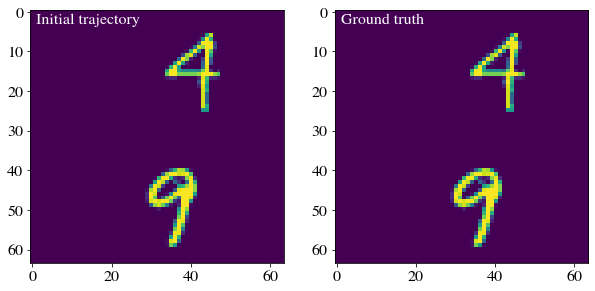

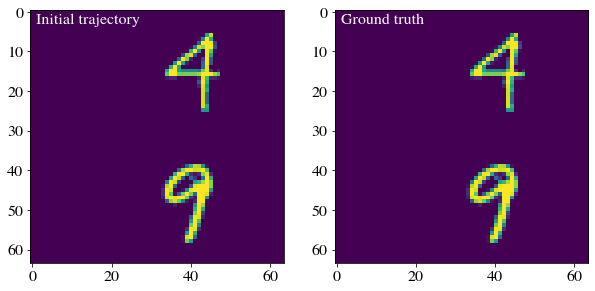

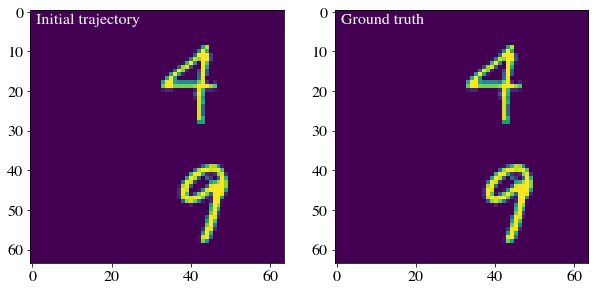

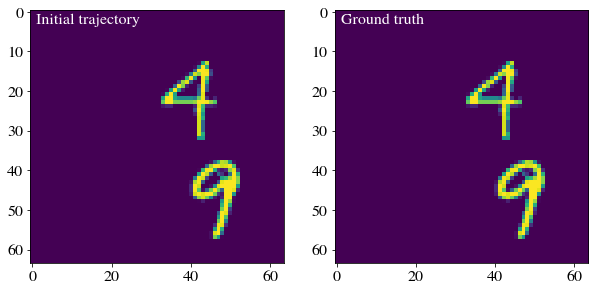

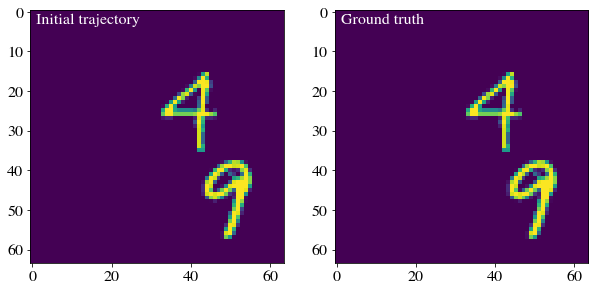

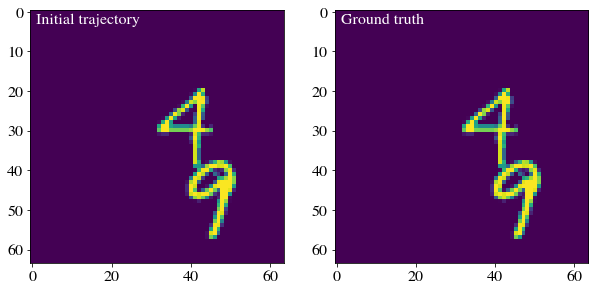

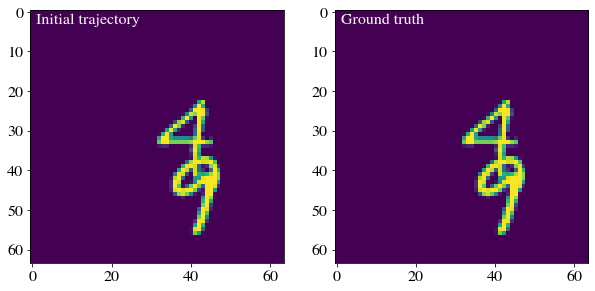

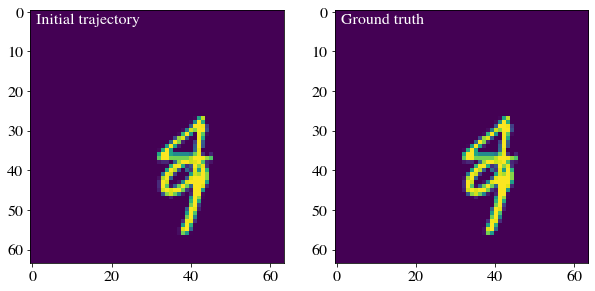

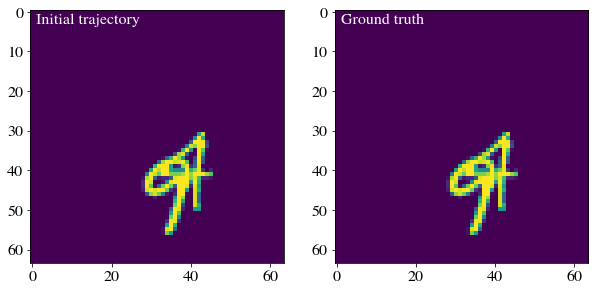

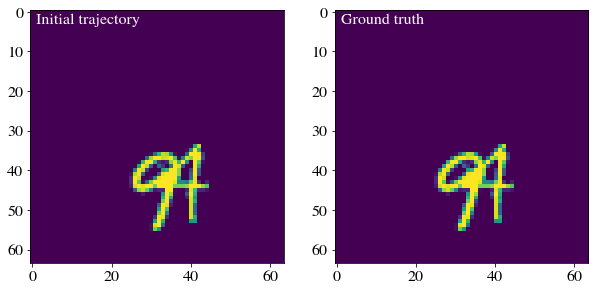

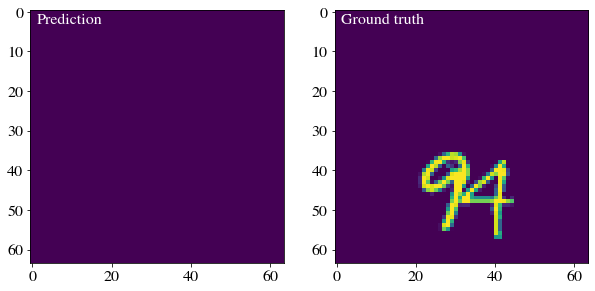

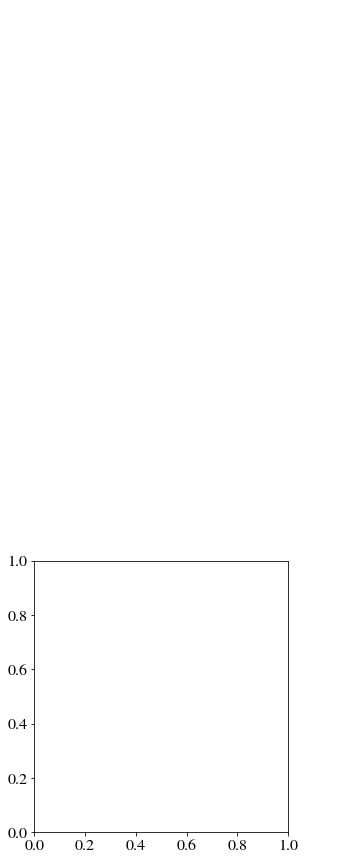

In [217]:
# Plot results
true_track = data[itest, :, :, :, 0]

for i in range(20):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= init_traj:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :])

    plt.savefig('anim_%i.png' % (i+1))
    #files.download('anim_%i.png' % (i+1))

In [183]:
np.where(data[itest, 0, :, :, 0])

(array([ 6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
         9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21,
        22, 22, 23, 23, 24, 24, 25, 25, 40, 40, 40, 40, 40, 40, 40, 41, 41,
        41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44,
        44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46,
        46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
        47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49,
        49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52,
        52, 